In [1]:
import pandas as pd
import plotly.express as px

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Analyzing the Texas Water Development Board's Groundwater Database
Full database avaiable here: [https://www.twdb.texas.gov/groundwater/data/gwdbrpt.asp](https://www.twdb.texas.gov/groundwater/data/gwdbrpt.asp) under `Downloads > Full GWDB Database Download`.

IMPORTANT: read the full README and pay attention to the data dictionary. This seems to be well documented and organized. Let's respect that.

Importing the well description table so we know which well numbers to use to pull data from the water levels table.

In [2]:
dtypes = {'StateWellNumber':str}
water_main = pd.read_csv('../data/20230920-GWDBDownload/GWDBDownload/WellMain.txt',sep='|',dtype=dtypes,encoding='ISO-8859-1')

/var/folders/2g/mqj0d6v95vbfcqgf7kpgrsrc0000gr/T/ipykernel_45691/2025797845.py:2: DtypeWarning: Columns (52) have mixed types. Specify dtype option on import or set low_memory=False.
  water_main = pd.read_csv('../data/20230920-GWDBDownload/GWDBDownload/WellMain.txt',sep='|',dtype=dtypes,encoding='ISO-8859-1')


In [3]:
water_main.head()

,StateWellNumber,County,RiverBasin,GMA,RWPA,GCD,AquiferCode,AquiferCodeDescription,AquiferId,Aquifer,Classification,AquiferPickMethod,LatitudeDD,Dlat,Mlat,Slat,LongitudeDD,Dlong,Mlong,Slong,CoordinateSource,Owner,Driller,WellDepth,DepthSource,LandSurfaceElevation,LandSurfaceElevationMethod,DrillingStartDate,DrillingMonth,DrillingDay,DrillingYear,DrillingEndDate,DrillingMethod,BoreHoleCompletion,WellType,Pump,PowerType,WellUse,WaterLevelStatus,CurrentWaterLevelWell,WaterQualityAvailable,CurrentWaterQualityWell,ReportingAgency,OtherDataAvailable,Remarks,WellReportTrackingNumber,PluggingReportTrackingNumber,USGSSiteNumber,TCEQSourceId,GCDWellNumber,OwnerWellNumber,OtherWellNumber,PreviousStateWellNumber,CreatedDate,LastUpdateDate
0,0140301,Dallam,Canadian,1,A - Panhandle,North Plains GCD,121OGDP,"Ogallala Formation, Dakota Group and Purgatoir...",58,Ogallala/Rita Blanca,Combination,NaN,36.493333,36,29,36.0,-103.039167,103,2,21.0,Global Positioning System - GPS,Poole Chemical Company Danny Poole,Dalhart Butane a Equipment Co,470.0,Driller's Log,4702.0,Interpolated From Topo Map,NaN,12.0,23.0,1974.0,1974-12-23,Mud (Hydraulic) Rotary,Gravel Pack w/Perforations,Withdrawal of Water,Turbine,Electric Motor,Irrigation,NaN,No,Yes,Yes,Texas Water Development Board,Drillers Log,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,2004-05-18,2023-07-28
1,0140302,Dallam,Canadian,1,A - Panhandle,North Plains GCD,121OGDP,"Ogallala Formation, Dakota Group and Purgatoir...",58,Ogallala/Rita Blanca,Combination,NaN,36.467500,36,28,3.0,-103.004444,103,0,16.0,+/- 1 Second,Gene Clark Clark Ranch,NaN,180.0,Memory of Owner,4644.0,Interpolated From Topo Map,NaN,NaN,NaN,1965.0,NaN,NaN,Open End,Withdrawal of Water,Piston,Windmill,Stock,NaN,No,No,No,Texas Water Development Board,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,2003-12-23,2022-12-02
2,0140601,Dallam,Canadian,1,A - Panhandle,North Plains GCD,211DKOP,Dakota Group and Purgatoire Formation,23,Rita Blanca,Minor,NaN,36.435000,36,26,6.0,-103.021389,103,1,17.0,Global Positioning System - GPS,Clark Ranch manager: Mike Sanchez,Dalhart Butane and Equipment Co.,390.0,Driller's Log,4692.0,Interpolated From Topo Map,NaN,1.0,8.0,1975.0,1975-01-08,Mud (Hydraulic) Rotary,Gravel Pack w/Perforations,Withdrawal of Water,Turbine,Gasoline Engine,Irrigation,NaN,No,Yes,No,Texas Water Development Board,Drillers Log,Formerly irrigation well. Reported yield 1000 ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-12-01,2020-01-16
3,0140901,Dallam,Canadian,1,A - Panhandle,North Plains GCD,121OGLL,Ogallala Formation,21,Ogallala,Major,NaN,36.383611,36,23,1.0,-103.015000,103,0,54.0,+/- 1 Second,Bernard Eads,John Lindsey,346.0,Person Other than Owner,4669.0,Interpolated From Topo Map,NaN,3.0,NaN,1954.0,NaN,NaN,NaN,Withdrawal of Water,Turbine,Natural-Gas Engine,Irrigation,NaN,No,No,No,Texas Water Development Board,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1966-08-30,2018-03-27
4,0140902,Dallam,Canadian,1,A - Panhandle,North Plains GCD,121OGLD,Ogallala Formation and Dakota Group,58,Ogallala/Rita Blanca,Combination,NaN,36.408333,36,24,30.0,-103.036944,103,2,13.0,Global Positioning System - GPS,Langford Ranch,NaN,160.0,Person Other than Owner,4690.0,Interpolated From Topo Map,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Withdrawal of Water,Piston,Windmill,Stock,NaN,No,No,No,Texas Water Development Board,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-10-01,2020-01-16


Which aquifer do we want? Assuming it might be more complicated than just grabbing Trinity.

In [ ]:
by_aquifer = water_main.groupby(['Aquifer','Classification']).size().reset_index().rename(columns={0:'wells'})

In [ ]:
by_aquifer.loc[by_aquifer['Aquifer'].str.contains('Trinity')].sort_values('wells',ascending=False)

Ok for now I'm just going to pull Trinity. We'll see if Liz has other feelings.

Let's create a list of all Trinity wells so we can use it to filter the water levels table.

In [ ]:
trinity_wells = water_main.loc[water_main['Aquifer'] == 'Trinity']
trinity_well_ids = list(trinity_wells['StateWellNumber'].values)

## Water levels

Import water levels now. Since we can see that the plain ol' Trinity is of class "major", we can import that dataset for now. But note that there are water level tables for "combination","minor" and "other unassigned" aquifer classification types.

Turns out we didn't need water main to provide the aquifer. That's also in water levels. Whatevs. 

But we will need ot convert some fields into dates so we can use them appropriately. I'm going to filter down the dataset by year first and then convert the dates so the system doesn't lose its mind.

In [4]:
water_levels = pd.read_csv('../data/20230920-GWDBDownload/GWDBDownload/WaterLevelsMajor.txt',sep='|',dtype=dtypes,encoding='ISO-8859-1')
trinity_levels = water_levels.loc[water_levels['Aquifer'] == 'Trinity']
trin_rec_levels = trinity_levels.loc[trinity_levels['MeasurementYear']>1989]
trin_rec_levels['date_fmtd'] = pd.to_datetime(trin_rec_levels['MeasurementDate'])

/var/folders/2g/mqj0d6v95vbfcqgf7kpgrsrc0000gr/T/ipykernel_45691/1452902779.py:1: DtypeWarning: Columns (8,17) have mixed types. Specify dtype option on import or set low_memory=False.
  water_levels = pd.read_csv('../data/20230920-GWDBDownload/GWDBDownload/WaterLevelsMajor.txt',sep='|',dtype=dtypes,encoding='ISO-8859-1')
/var/folders/2g/mqj0d6v95vbfcqgf7kpgrsrc0000gr/T/ipykernel_45691/1452902779.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trin_rec_levels['date_fmtd'] = pd.to_datetime(trin_rec_levels['MeasurementDate'])


In [5]:
print(len(water_levels))
print(len(trinity_levels))
print(len(trin_rec_levels))

1298332
320425
285232


In [7]:
print(trin_rec_levels['date_fmtd'].max())
print(trin_rec_levels['date_fmtd'].min())

2023-08-31 00:00:00
1899-12-30 00:00:00


In [8]:
print(trin_rec_levels.dtypes)
display(trin_rec_levels.head())

StateWellNumber                object
County                         object
Aquifer                        object
Status                         object
MeasurementMonth              float64
MeasurementDay                float64
MeasurementYear               float64
MeasurementDate                object
MeasurementTime                object
DepthFromLSD                  float64
LandElevation                 float64
LandElevationMethod            object
WaterElevation                float64
MeasurementNumber               int64
MeasuringAgency                object
MethodOfMeasurement            object
Remarks                        object
Comments                       object
CreatedDate                    object
LastUpdateDate                 object
date_fmtd              datetime64[ns]
dtype: object


,StateWellNumber,County,Aquifer,Status,MeasurementMonth,MeasurementDay,MeasurementYear,MeasurementDate,MeasurementTime,DepthFromLSD,LandElevation,LandElevationMethod,WaterElevation,MeasurementNumber,MeasuringAgency,MethodOfMeasurement,Remarks,Comments,CreatedDate,LastUpdateDate,date_fmtd
124015,1707402,Red River,Trinity,Publishable,1.0,9.0,1990.0,1990-01-09,NaN,-17.06,350.0,Interpolated From Topo Map,367.06,1,Texas Water Development Board,Pressure Gage,NaN,NaN,NaN,NaN,1990-01-09
124016,1707402,Red River,Trinity,Publishable,1.0,8.0,1991.0,1991-01-08,NaN,-27.70,350.0,Interpolated From Topo Map,377.70,1,Texas Water Development Board,Pressure Gage,NaN,NaN,NaN,NaN,1991-01-08
124017,1707402,Red River,Trinity,No Measurement,1.0,20.0,1992.0,1992-01-20,NaN,NaN,350.0,Interpolated From Topo Map,NaN,1,Texas Water Development Board,NaN,Well temporarily inaccessible due to impassab...,NaN,NaN,NaN,1992-01-20
124018,1707402,Red River,Trinity,Publishable,1.0,12.0,1993.0,1993-01-12,NaN,-17.06,350.0,Interpolated From Topo Map,367.06,1,Texas Water Development Board,Pressure Gage,NaN,NaN,NaN,NaN,1993-01-12
124019,1707402,Red River,Trinity,Publishable,1.0,11.0,1994.0,1994-01-11,NaN,-22.60,350.0,Interpolated From Topo Map,372.60,1,Texas Water Development Board,Pressure Gage,NaN,NaN,NaN,NaN,1994-01-11


Ok cool but all of this is still on a well level. I think we need to aggregate and get this on the county + month + year level.

First how many counties are we talkin' bout?

In [12]:
trin_rec_levels.groupby('County').size().reset_index().rename(columns={0:'wells'}).sort_values('wells',ascending=False)

,County,wells
6,Burnet,43836
24,Hays,34080
30,Kendall,32802
31,Kerr,30896
2,Bexar,20911
26,Hood,11493
1,Bell,11450
41,Parker,10343
48,Travis,10173
12,Coryell,8076


Le yipe. Lets not do by county.

Also I'm noticing some `MeasurementMonth == 0`. Is that like... an annual average? We'll wanna test that out.

In [66]:
by_monthyear = trin_rec_levels.groupby(['MeasurementYear','MeasurementMonth'])['WaterElevation'].mean().reset_index()
by_monthyear

,MeasurementYear,MeasurementMonth,WaterElevation
0,1990.0,0.0,756.000000
1,1990.0,1.0,761.944080
2,1990.0,2.0,844.548613
3,1990.0,3.0,1078.793924
4,1990.0,4.0,724.408000
5,1990.0,5.0,833.974839
6,1990.0,6.0,862.495750
7,1990.0,7.0,816.778333
8,1990.0,8.0,929.921053
9,1990.0,9.0,850.722581


---------------------
### An interlude to see what's up with month 0

Ok let's test the `MeasurementMonth == 0` hypothesis so we know if we should remove that. Just pick some rando wells and then do some groupings on them.

I actually tried picking rando wells and seems like not every well has a `MeasurementMonth == 0` case. HOWEVER, when i tested this assumption on some wells that def have a month 0, I found that they then don't have any other months! And upon further FURTHER analysis, there are like only 7 wells that have a month zero so let's just ditch it.

In [63]:
rando_well_ids = trin_rec_levels.loc[trin_rec_levels['MeasurementMonth'] == 0].sample(5)['StateWellNumber'].tolist()
rando_yr_num = [1994]#trin_rec_levels.sample()['MeasurementYear'].tolist()

rando_well_data = trin_rec_levels.loc[(trin_rec_levels['StateWellNumber'].isin(rando_well_ids))&(trin_rec_levels['MeasurementYear'].isin(rando_yr_num))]

rando_annual_assump = rando_well_data.loc[rando_well_data['MeasurementMonth'] == 0]
rando_annual_calc = rando_well_data.loc[~(rando_well_data['MeasurementMonth'] == 0)].groupby('StateWellNumber')['WaterElevation'].mean()

In [64]:
rando_annual_assump

,StateWellNumber,County,Aquifer,Status,MeasurementMonth,MeasurementDay,MeasurementYear,MeasurementDate,MeasurementTime,DepthFromLSD,LandElevation,LandElevationMethod,WaterElevation,MeasurementNumber,MeasuringAgency,MethodOfMeasurement,Remarks,Comments,CreatedDate,LastUpdateDate,date_fmtd
125210,1820703,Grayson,Trinity,Publishable,0.0,0.0,1994.0,NaN,NaN,575.0,720.0,Interpolated From Topo Map,145.0,1,Municipal Water Agency or PWS Corporation,Air Line,NaN,NaN,1995-04-03,1995-04-03,NaT
125228,1820709,Grayson,Trinity,Publishable,0.0,0.0,1994.0,NaN,NaN,632.0,730.0,Interpolated From Topo Map,98.0,1,Municipal Water Agency or PWS Corporation,Air Line,NaN,NaN,1995-04-03,1995-04-03,NaT
125440,1828404,Grayson,Trinity,Publishable,0.0,0.0,1994.0,NaN,NaN,667.0,730.0,Interpolated From Topo Map,63.0,1,Municipal Water Agency or PWS Corporation,Logging Sonde,NaN,NaN,1995-04-03,1995-04-03,NaT
125489,1828803,Grayson,Trinity,Publishable,0.0,0.0,1994.0,NaN,NaN,695.0,780.0,Interpolated From Topo Map,85.0,1,Municipal Water Agency or PWS Corporation,Air Line,NaN,NaN,1995-04-03,1995-04-03,NaT


In [62]:
rando_annual_calc

Series([], Name: WaterElevation, dtype: float64)

In [65]:
trin_rec_levels.loc[trin_rec_levels['MeasurementMonth'] == 0].groupby('County').size()

County
Bell       1
Coryell    1
Grayson    4
Travis     1
dtype: int64

------------------

As we saw, month 0 isn't good data and it's minimal so let's drop it.

In [81]:
by_monthyear = by_monthyear.loc[by_monthyear['MeasurementMonth']>0]
by_monthyear['month'] = by_monthyear['MeasurementMonth']
by_monthyear['year'] = by_monthyear['MeasurementYear']
by_monthyear['monthyear'] = pd.to_datetime(by_monthyear[['month','year']].assign(day=1))

In [82]:
by_monthyear.head()

,MeasurementYear,MeasurementMonth,WaterElevation,month,year,monthyear
1,1990.0,1.0,761.944080,1.0,1990.0,1990-01-01
2,1990.0,2.0,844.548613,2.0,1990.0,1990-02-01
3,1990.0,3.0,1078.793924,3.0,1990.0,1990-03-01
4,1990.0,4.0,724.408000,4.0,1990.0,1990-04-01
5,1990.0,5.0,833.974839,5.0,1990.0,1990-05-01


/Users/alexandra.kanik/CHRON/projects/_2023/sa-water-levels/sa-water-levels/env/lib/python3.9/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



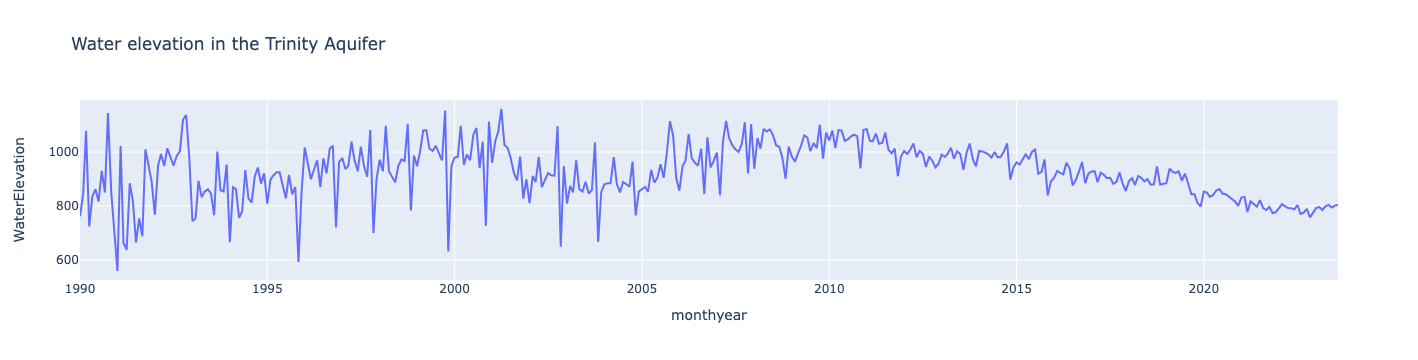

In [83]:
fig = px.line(by_monthyear, x='monthyear', y='WaterElevation', title='Water elevation in the Trinity Aquifer')
fig.show()

This is kinda crazy. Looks like every low spike has been in November. I wonder if that's BS or what...